# Logistic Regression and Multi-layer Feed-forward Neural Network for Digit Recognition

This practical session is designed to implement Logistic Regression (LR) and Multi-layer Feed-forward Neural Network (MFNN) for handwritten digit recognition. [The MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) is used for training and testing LR and MFNN. 

## Dataset
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of handwritten grayscale digit images. All handwritten digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. A grayscale image is nothing but a 2D array of integers between 0 and 255. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey. Below is some examples of [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits:

![MNIST](./images/mnist-samples.png)


## References
[1] http://yann.lecun.com/exdb/mnist/

[2] https://pjreddie.com/projects/mnist-in-csv/

## Dataset Loading and Visualisation
The following function loads train and test handwritten digit image samples from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [4]:
%matplotlib inline
import matplotlib.pyplot as pl

import numpy as np

In [5]:
def load_dataset(train_dataset='mnist_train.csv', test_dataset='mnist_test.csv'):
    """
    Loads and returns train and test datasets.
    """
    data_train = np.genfromtxt(fname=train_dataset, delimiter=',')
    y_train = data_train[:,0]
    x_train = data_train[:,1:]
    data_test = np.genfromtxt(fname=test_dataset, delimiter=',')
    y_test = data_test[:,0]
    x_test = data_test[:,1:]
    return (x_train, y_train, x_test, y_test)

The following script calls function `load_dataset()` to train and test datasets. _Be patient as it may take some time to load datasets!_

In [6]:
x_train, y_train, x_test, y_test = load_dataset()

IOError: mnist_train.csv not found.

In [5]:
x_train.shape

(60000, 784)

Each row of `x_train` and `x_test` variables is a 1D vector comprised of 784 (28 * 28) integers and refers to an unpacked handwritten digit image. The following function takes a 1D vector array as input and returns the corresponding 2D representation as image.

In [4]:
def vector2image(image_vector, image_height=28, image_width=28):
    """
    Returns image representation of the input 1D vector.
    """
    image = np.reshape(image_vector, (image_height, image_width))
    return image

Now you can use `vector2image()` function to convert a 1D feature vector to 2D image for visualisation purposes, e.g.:

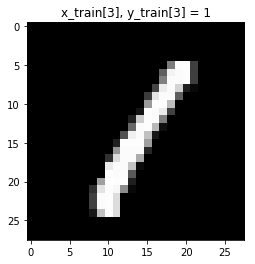

In [5]:
index = 3
image = vector2image(x_train[index])
pl.figure()
pl.imshow(image, cmap='gray')
pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(int(y_train[index])))
pl.show()

You may also need the following function to convert a 2D grayscale image to 1D vector representation.

In [6]:
def image2vector(image):
    """
    Returns vector representation of the input 2D image.
    """
    image_height, image_width = image.shape
    image_vector = np.reshape(image, image_height*image_width)
    return image_vector

Thus, `vector2image(image2vector(vector2image(x_train[index])))` must produce exactly same output with that of `vector2image(x_train[index])`, i.e.:

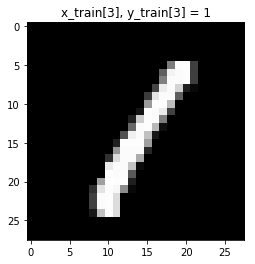

In [7]:
    image = vector2image(image2vector(vector2image(x_train[index])))
    pl.figure()
    pl.imshow(image, cmap='gray')
    pl.title('x_train[' + str(index) + '], ' + 'y_train[' + str(index) + '] = ' + str(int(y_train[index])))
    pl.show()

Now, let's produce an image that is similar to what you see on the very first markdown cell by selecting samples from `x_train` and `y_train`!

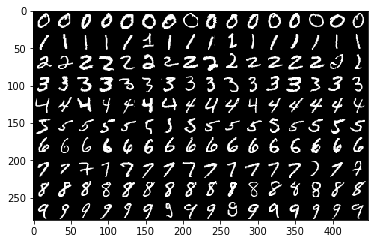

In [8]:
C = 10 # number of digits
R = 16 # images per row
for c in np.arange(C):
    for r in np.arange(R):
        image = vector2image(x_train[y_train==c][r])
        if r == 0:
            image_digits_row = image
        else:
            image_digits_row = np.hstack((image_digits_row, image))
    if c == 0:
        image_digits = image_digits_row
    else:
        image_digits = np.vstack((image_digits, image_digits_row))
pl.figure()
pl.imshow(image_digits, cmap='gray')
# save a copy of this image as png file under ./images folder
pl.imsave('./images/mnist-samples.png', image_digits, cmap='gray') 

We are ready to implement LR classifier for digit recognition.

## Logistic Regression

In [29]:
class LR:
    def __init__(self, W):
        self.W = W
        self.delta = 0.000001
        self.epoch_max = 100000
        
    def parameters(self):
        return self.W
                
    def activation(self, s):
        return 1.0 / (1 + np.exp(-s)) # sigmoid function as activation function
    
    def activation_prime(self, s):
        return (self.activation(s) * (1.0 - self.activation(s))) # the derivative of activation function
    
    def feedforward(self, X):
        S = np.dot(X, self.W)
        U = self.activation(S)
        return (U)        
        
    def learn(self, X, Y, learning_rate):        
        C =  len(np.unique(Y))
        N = X.shape[0]
        Yv = np.zeros((N, C))
        Yv[np.arange(N), Y.astype(np.int)] = 1.0
        is_converged = False
        epoch = 1
        while not is_converged:
            U = self.feedforward(X)
      
            E = (U - Yv)
    
            D = U * (1-U) * E
            print(np.mean(D))
            print(X.shape)
            MSE = 1.0 / (2 * N) * np.sum(np.sum(E**2, axis=1))
            if (epoch%100) == 0:
                ACC = self.accuracy(X, Y)
                print('epoch = {0}, MSE = {1:.3f}, ACC = {2:.3f}'.format(epoch, MSE, ACC))
            Wprev = self.W.copy()
            self.W = self.W - learning_rate * (1.0/N )* np.dot(X.T, D)
            epoch += 1
            print( (np.max(np.abs(Wprev - self.W))))
            if (np.max(np.abs(Wprev - self.W)) <= self.delta) or (epoch >=self.epoch_max):
                is_converged = True        
        
    def classify(self, X):
        U = self.feedforward(X)
        L = np.argmax(U, axis=1)
        return L
    
    def accuracy(self, X, Y):
        N = X.shape[0]
        L = self.classify(X)
        acc = np.sum(L == Y) / N

        return acc
    
    def confusion_matrix(self, X, Y):
        L = self.accuracy(X, Y)
        labels = np.unique(Y).astype(int)
        conf_mat = np.zeros((len(labels), len(labels)))
    
        for i in np.arange(len(labels)):
            for j in np.arange(len(labels)):
                #print(L)
                #print(Y==labels[j])
                conf_mat[i, j] = np.sum((L==labels[i]) and (Y==labels[j]))
            
    
        

### Train Logistic Regression

In [30]:
N_train = x_train.shape[0]
x_train_t = np.hstack((np.ones((N_train, 1)), x_train))
x_train_t = x_train_t / np.max(x_train_t)
N_test = x_test.shape[0]
x_test_t = np.hstack((np.ones((N_test, 1)), x_test))
x_test_t = x_test_t / np.max(x_train_t)
C = len(np.unique(y_train))
d = x_train_t.shape[1]

W = np.random.randn(d, C) 

logreg = LR(W)
logreg.learn(x_train_t, y_train, 2)
#logreg.confusion_matrix( x_train_t, y_train)

0.018469302403356272
(60000, 785)
0.03489064009953802
0.017796360625813405
(60000, 785)
0.032790023354145714
0.01701708806586914
(60000, 785)
0.02933359078295228
0.016374605055426143
(60000, 785)
0.027200945707488988
0.01588303611449703
(60000, 785)
0.03017764143597068
0.015308646645962196
(60000, 785)
0.03270862769931382
0.01438194325626776
(60000, 785)
0.034182822694123094
0.013130849555161547
(60000, 785)
0.032942708418340905
0.011758989213258264
(60000, 785)
0.028893370309470146
0.01041654516360978
(60000, 785)
0.023703705092530947
0.009218621059081259
(60000, 785)
0.022112752625663645
0.008226386290215939
(60000, 785)
0.02043203893584561
0.007362093048340321
(60000, 785)
0.01848139581461139
0.0066160138984899045
(60000, 785)
0.016389059348971224
0.0059833581642678765
(60000, 785)
0.014639021376393724
0.005439442917044483
(60000, 785)
0.013423044616044141
0.004974567051397508
(60000, 785)
0.012289422842377296
0.004578482362574982
(60000, 785)
0.011268456418602198
0.0042358841200427

KeyboardInterrupt: 

In [11]:
y_train[:][0:5].shape

(5,)

In [12]:
X = x_train[:][0:5]
Y = y_train[:][0:5]
C =  len(np.unique(Y))
N = X.shape[0]
Yv = np.zeros((N, C))
Yv[np.arange(N), 
   Y.astype(np.int)] = 1.0
Yv.shape

IndexError: index 5 is out of bounds for axis 1 with size 5

### Test Accuracy of the Trained Logistic Regression

In [ ]:
print('{0:.3f}'.format(logreg.accuracy(x_test_t, y_test)))